In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
import string as s

from nltk.corpus import stopwords
from sklearn.metrics import make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix, roc_curve, auc

from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.metrics  import f1_score,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

# Data loading and visualization

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ag-news-classification-dataset/train.csv
/kaggle/input/ag-news-classification-dataset/test.csv
/kaggle/input/more-data/bbc_news.json


In [3]:
train_data = pd.read_csv('/kaggle/input/ag-news-classification-dataset/train.csv', header=0,names=['ID','Title','Desc'])
test_data = pd.read_csv('/kaggle/input/ag-news-classification-dataset/test.csv', header=0,names=['ID','Title','Desc'])
#df = pd.concat([train_data,test_data])

train_data['text'] = train_data['Title'] + ' ' + train_data['Desc']
test_data['text'] = test_data['Title'] + ' ' + test_data['Desc']


In [4]:
train_data.head()

,ID,Title,Desc,text
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",Wall St. Bears Claw Back Into the Black (Reute...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Carlyle Looks Toward Commercial Aerospace (Reu...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Iraq Halts Oil Exports from Main Southern Pipe...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","Oil prices soar to all-time record, posing new..."


In [5]:
test_data.head()

print(train_data.shape)
print(test_data.shape)

(120000, 4)
(7600, 4)


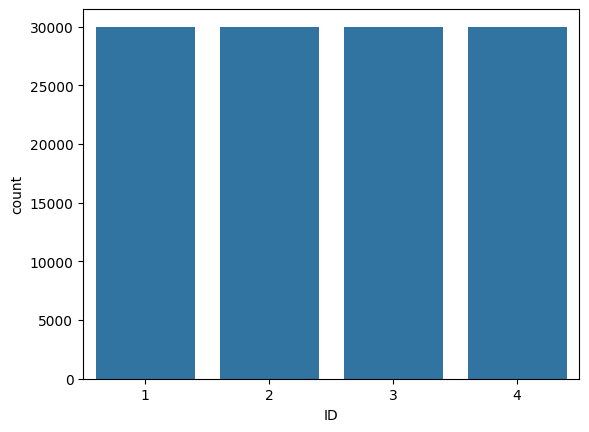

In [6]:
sns.countplot(x = 'ID', data = train_data)
plt.show()

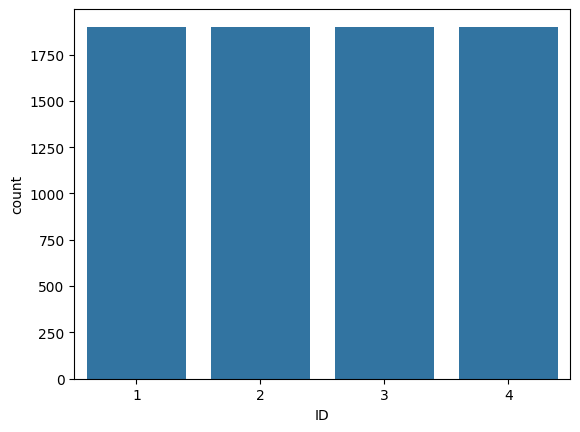

In [7]:
sns.countplot(x = 'ID', data = test_data)
plt.show()

In [8]:
train_x = train_data.text[:]
test_x = test_data.text
train_y = train_data.ID[:]
test_y = test_data.ID

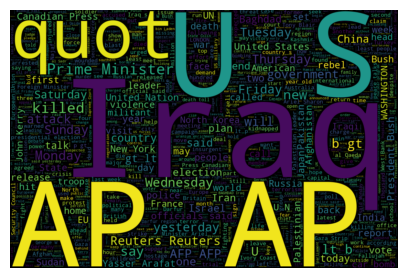

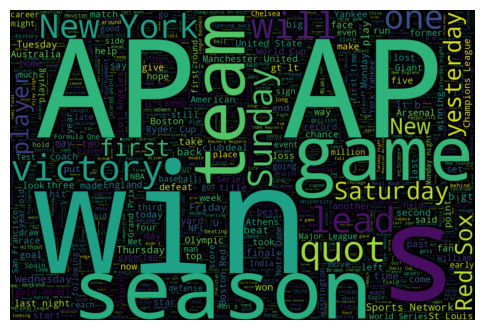

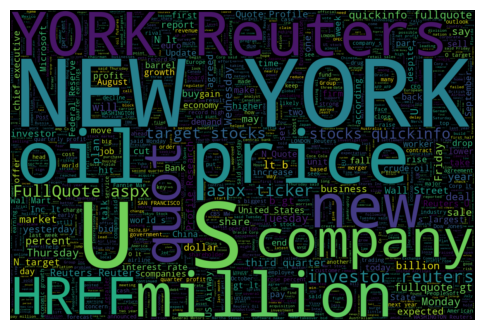

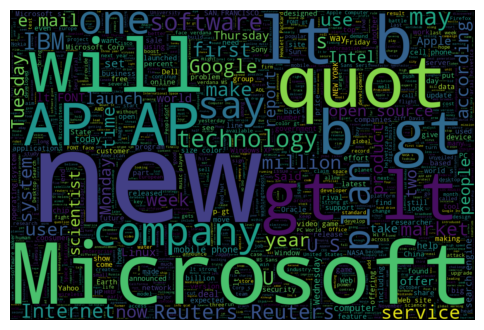

In [9]:
# train_x = train_data.text[:60000]
# test_x = test_data.text
# train_y = train_data.ID[:60000]
# test_y = test_data.ID

world = train_data[train_data['ID'] == 1]['text']
plt.figure(figsize=(5, 5))
wordcloud = WordCloud(min_font_size=3, max_words=2500, width=1200, height=800).generate(" ".join(world))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

sports_desc = train_data.loc[train_data['ID'] == 2, 'text']
plt.figure(figsize=(6, 6))
wordcloud = WordCloud(min_font_size=3, max_words=2500, width=1200, height=800).generate(" ".join(sports_desc))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

biz_desc = train_data.loc[train_data['ID'] == 3, 'text']
plt.figure(figsize=(6, 6))
wordcloud = WordCloud(min_font_size=3, max_words=2500, width=1200, height=800).generate(" ".join(biz_desc))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

sci_desc = train_data.loc[train_data['ID'] == 4, 'text']
plt.figure(figsize=(6, 6))
wordcloud = WordCloud(min_font_size=3, max_words=2500, width=1200, height=800).generate(" ".join(sci_desc))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Preprocessing

In [10]:
import html
import re

def clean_html_noise(text: str) -> str:
   
    text = html.unescape(text)
    
   
    text = re.sub(r"<.*?>", "", text)
    
  
    text = re.sub(r"\s+", " ", text).strip()
    
    return text

train_x = train_x.apply(clean_html_noise)
test_x = test_x.apply(clean_html_noise)

In [11]:
def url_remove(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)
train_x = train_x.apply(url_remove)
test_x = test_x.apply(url_remove)

In [12]:
def word_tokenize(text):
    token = re.findall("[\w']+", text)
    return token
train_x = train_x.apply(word_tokenize)
test_x = test_x.apply(word_tokenize)

train_x = train_x.apply(lambda x: [word.lower() for word in x])
test_x = test_x.apply(lambda x: [word.lower() for word in x])

<>:2: SyntaxWarning: invalid escape sequence '\w'
<>:2: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipykernel_55/2604863595.py:2: SyntaxWarning: invalid escape sequence '\w'
  token = re.findall("[\w']+", text)


In [13]:
def remove_stopwords(lst):
    stop_words = set(stopwords.words('english'))
    return [word for word in lst if word.lower() not in stop_words]
train_x = train_x.apply(remove_stopwords)
test_x = test_x.apply(remove_stopwords)

In [14]:
import string
def remove_punctuations(lst):
    return [''.join(char for char in word if char not in string.punctuation) for word in lst]
train_x = train_x.apply(remove_punctuations)
test_x = test_x.apply(remove_punctuations)

In [15]:
def remove_number(lst):
    return [''.join(char for char in word if char not in string.digits) for word in lst if word]
train_x = train_x.apply(remove_number)
test_x = test_x.apply(remove_number)

In [16]:
from nltk.stem import PorterStemmer
def stemming(text):
    porter_stemmer = PorterStemmer()
    return [porter_stemmer.stem(word) for word in text]
train_x = train_x.apply(stemming)
test_x = test_x.apply(stemming)

In [17]:
def remove_extra_words(word_list):
    stopwords = ['href', 'lt', 'gt', 'ii', 'iii', 'ie', 'quot', 'com']
    cleaned_list = []
    for word in word_list:
        if word not in stopwords:
            cleaned_list.append(word)
    return cleaned_list
train_x = train_x.apply(remove_extra_words)
test_x = test_x.apply(remove_extra_words)

In [18]:
def join_words_with_space(sentence):
    joined_sentence = ' '.join(sentence)
    return joined_sentence

train_x = train_x.apply(join_words_with_space)
test_x = test_x.apply(join_words_with_space)

# Training

## Uni-gram 

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    min_df=8,
    ngram_range=(1, 1)
)

train_arr = tfidf.fit_transform(train_x)
test_arr  = tfidf.transform(test_x)

total_features = train_arr.shape[1]

print("No. of features extracted (TF-IDF):", total_features)
print("First 100 feature names:")
print(list(tfidf.vocabulary_.keys())[:100])


print(f"Total features: {total_features}")

No. of features extracted (TF-IDF): 13740
First 100 feature names:
['wall', 'st', 'bear', 'claw', 'back', 'black', 'reuter', 'short', 'seller', 'street', 'dwindl', 'band', 'ultra', 'cynic', 'see', 'green', 'carlyl', 'look', 'toward', 'commerci', 'aerospac', 'privat', 'invest', 'firm', 'group', 'reput', 'make', 'well', 'time', 'occasion', 'controversi', 'play', 'defens', 'industri', 'quietli', 'place', 'bet', 'anoth', 'part', 'market', 'oil', 'economi', 'cloud', 'stock', 'outlook', 'soar', 'crude', 'price', 'plu', 'worri', 'earn', 'expect', 'hang', 'next', 'week', 'depth', 'summer', 'doldrum', 'iraq', 'halt', 'export', 'main', 'southern', 'pipelin', 'author', 'flow', 'intellig', 'show', 'rebel', 'militia', 'could', 'strike', 'infrastructur', 'offici', 'said', 'saturday', 'record', 'pose', 'new', 'menac', 'us', 'afp', 'world', 'toppl', 'strain', 'wallet', 'present', 'econom', 'bare', 'three', 'month', 'presidenti', 'elect', 'end', 'near', 'year', 'low', 'slightli', 'higher', 'friday']
To

In [20]:
#This function finds the F1-score and Accuracy of the trained model
def eval_model(y_test,y_pred):
    results = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, average='macro'),
        "recall": recall_score(y_test, y_pred, average='macro'),
        "f1": f1_score(y_test, y_pred, average='macro')
    }

    print("Test set accuracy: {:.4f}".format(results["accuracy"]))
    print("Test set precision: {:.4f}".format(results["precision"]))
    print("Test set recall: {:.4f}".format(results["recall"]))
    print("Test set F1: {:.4f}".format(results["f1"]))
    print("F1 per class:", f1_score(y_test, y_pred, average=None))



In [21]:
#Function for Displaying the Confusion Matrix - This function displays the confusion matrix of the model
def confusion_mat(color):
    cof=confusion_matrix(test_y, pred)
    cof=pd.DataFrame(cof, index=[i for i in range(1,5)], columns=[i for i in range(1,5)])
    sns.set(font_scale=1.5)
    plt.figure(figsize=(8,8));

    sns.heatmap(cof, cmap=color,linewidths=1, annot=True,square=True, fmt='d', cbar=False,xticklabels=['World','Sports','Business','Science'],yticklabels=['World','Sports','Business','Science']);
    plt.xlabel("Predicted Classes");
    plt.ylabel("Actual Classes");

In [22]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
}
grid_search = GridSearchCV(
    estimator=MultinomialNB(),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy', # Bạn có thể đổi thành 'f1_macro' nếu dữ liệu mất cân bằng
    n_jobs=-1,
    verbose=1
)

# 3. Huấn luyện
print("Đang thực hiện Grid Search...")
grid_search.fit(train_arr, train_y)

# ==============================================================================
# 4. XUẤT KẾT QUẢ CHI TIẾT (KHÔNG LÀM TRÒN)
# ==============================================================================
cv_results = pd.DataFrame(grid_search.cv_results_)

# Lấy các cột quan trọng
results_summary = cv_results[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]

# Đổi tên cột
results_summary.columns = ['Tham số', 'Độ chính xác TB', 'Độ lệch chuẩn', 'Xếp hạng']

# Sắp xếp theo xếp hạng
results_summary = results_summary.sort_values(by='Xếp hạng')

# --- QUAN TRỌNG: ĐỊNH DẠNG HIỂN THỊ ---
# Dùng style.format để hiển thị 6 chữ số thập phân
print("\n--- BẢNG KẾT QUẢ CHI TIẾT ---")
try:
    # Hiển thị đẹp nếu chạy trong Jupyter Notebook
    display(results_summary.style.format({
        'Độ chính xác TB': '{:.6f}',
        'Độ lệch chuẩn': '{:.6f}'
    }))
except NameError:
    # Fallback nếu không có hàm display (chạy terminal)
    print(results_summary.to_string(formatters={
        'Độ chính xác TB': '{:.6f}'.format,
        'Độ lệch chuẩn': '{:.6f}'.format
    }))

print(f"Tham số tốt nhất: {grid_search.best_params_}")
print(f"Độ chính xác tốt nhất trên tập Validation: {grid_search.best_score_:.4f}")

NB_MN = grid_search.best_estimator_

pred = NB_MN.predict(test_arr)

print("first 20 actual labels")
print(test_y.tolist()[:20])
print("first 20 predicted labels")
print(pred.tolist()[:20])

Đang thực hiện Grid Search...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

--- BẢNG KẾT QUẢ CHI TIẾT ---


,Tham số,Độ chính xác TB,Độ lệch chuẩn,Xếp hạng
3,{'alpha': 0.5},0.895442,0.010229,1
2,{'alpha': 0.1},0.894808,0.010572,2
4,{'alpha': 1.0},0.894742,0.009777,3
5,{'alpha': 2.0},0.894258,0.009228,4
6,{'alpha': 5.0},0.892333,0.009037,5
1,{'alpha': 0.01},0.891575,0.010837,6
7,{'alpha': 10.0},0.889433,0.009274,7
0,{'alpha': 0.001},0.887542,0.011297,8


Tham số tốt nhất: {'alpha': 0.5}
Độ chính xác tốt nhất trên tập Validation: 0.8954
first 20 actual labels
[3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
first 20 predicted labels
[3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 3]


In [23]:
eval_model(test_y,pred)

c=round(accuracy_score(test_y,pred)*100,3)

Test set accuracy: 0.8971
Test set precision: 0.8969
Test set recall: 0.8971
Test set F1: 0.8969
F1 per class: [0.89975942 0.96076903 0.85563194 0.87147335]


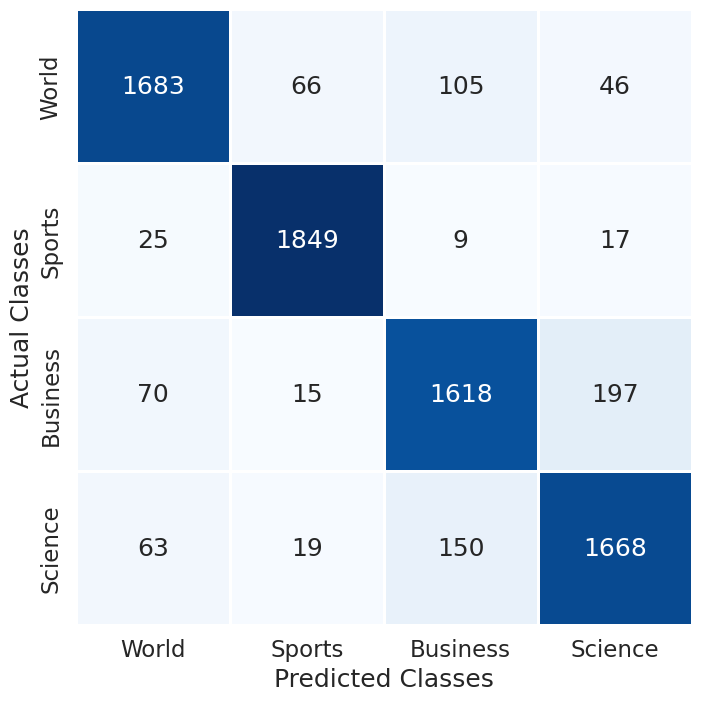

In [24]:
confusion_mat('Blues')

## Bi-gram

In [25]:
tfidf = TfidfVectorizer(
    min_df=8,
    ngram_range=(2, 2)
)

train_arr = tfidf.fit_transform(train_x)
test_arr  = tfidf.transform(test_x)

total_features = train_arr.shape[1]

print("No. of features extracted (TF-IDF):", total_features)
print("First 100 feature names:")
print(list(tfidf.vocabulary_.keys())[:100])


print(f"Total features: {total_features}")

No. of features extracted (TF-IDF): 44518
First 100 feature names:
['wall st', 'claw back', 'back black', 'reuter reuter', 'wall street', 'see green', 'reuter privat', 'privat invest', 'invest firm', 'carlyl group', 'play defens', 'place bet', 'oil economi', 'outlook reuter', 'soar crude', 'crude price', 'worri economi', 'economi outlook', 'earn expect', 'hang stock', 'stock market', 'market next', 'next week', 'oil export', 'pipelin southern', 'southern iraq', 'rebel militia', 'oil offici', 'offici said', 'said saturday', 'oil price', 'price soar', 'time record', 'us economi', 'economi afp', 'afp afp', 'world oil', 'present new', 'new econom', 'three month', 'month us', 'us presidenti', 'presidenti elect', 'stock end', 'end near', 'near year', 'year low', 'low reuter', 'reuter stock', 'end slightli', 'slightli higher', 'higher friday', 'near low', 'low year', 'year oil', 'price surg', 'surg past', 'posit outlook', 'comput maker', 'maker dell', 'dell inc', 'inc dell', 'money fund', 'fe

In [26]:
print("Đang thực hiện Grid Search...")
grid_search.fit(train_arr, train_y)

# ==============================================================================
# 4. XUẤT KẾT QUẢ CHI TIẾT (KHÔNG LÀM TRÒN)
# ==============================================================================
cv_results = pd.DataFrame(grid_search.cv_results_)

# Lấy các cột quan trọng
results_summary = cv_results[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]

# Đổi tên cột
results_summary.columns = ['Tham số', 'Độ chính xác TB', 'Độ lệch chuẩn', 'Xếp hạng']

# Sắp xếp theo xếp hạng
results_summary = results_summary.sort_values(by='Xếp hạng')

# --- QUAN TRỌNG: ĐỊNH DẠNG HIỂN THỊ ---
# Dùng style.format để hiển thị 6 chữ số thập phân
print("\n--- BẢNG KẾT QUẢ CHI TIẾT ---")
try:
    # Hiển thị đẹp nếu chạy trong Jupyter Notebook
    display(results_summary.style.format({
        'Độ chính xác TB': '{:.6f}',
        'Độ lệch chuẩn': '{:.6f}'
    }))
except NameError:
    # Fallback nếu không có hàm display (chạy terminal)
    print(results_summary.to_string(formatters={
        'Độ chính xác TB': '{:.6f}'.format,
        'Độ lệch chuẩn': '{:.6f}'.format
    }))

# 4. In kết quả tốt nhất
print(f"Tham số tốt nhất: {grid_search.best_params_}")
print(f"Độ chính xác tốt nhất trên tập Validation: {grid_search.best_score_:.4f}")

# 5. Gán mô hình tốt nhất vào biến NB_MN để dùng tiếp cho các đoạn code đánh giá bên dưới
NB_MN = grid_search.best_estimator_

# 6. Dự đoán trên tập test
pred = NB_MN.predict(test_arr)

print("first 20 actual labels")
print(test_y.tolist()[:20])
print("first 20 predicted labels")
print(pred.tolist()[:20])

Đang thực hiện Grid Search...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

--- BẢNG KẾT QUẢ CHI TIẾT ---


,Tham số,Độ chính xác TB,Độ lệch chuẩn,Xếp hạng
3,{'alpha': 0.5},0.872208,0.010904,1
4,{'alpha': 1.0},0.872058,0.011079,2
5,{'alpha': 2.0},0.871250,0.011479,3
2,{'alpha': 0.1},0.870175,0.011158,4
6,{'alpha': 5.0},0.868242,0.012309,5
1,{'alpha': 0.01},0.865067,0.011694,6
7,{'alpha': 10.0},0.864675,0.012275,7
0,{'alpha': 0.001},0.860583,0.011599,8


Tham số tốt nhất: {'alpha': 0.5}
Độ chính xác tốt nhất trên tập Validation: 0.8722
first 20 actual labels
[3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
first 20 predicted labels
[3, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3]


Test set accuracy: 0.8770
Test set precision: 0.8764
Test set recall: 0.8770
Test set F1: 0.8766
F1 per class: [0.87724785 0.9394648  0.84477692 0.84486874]


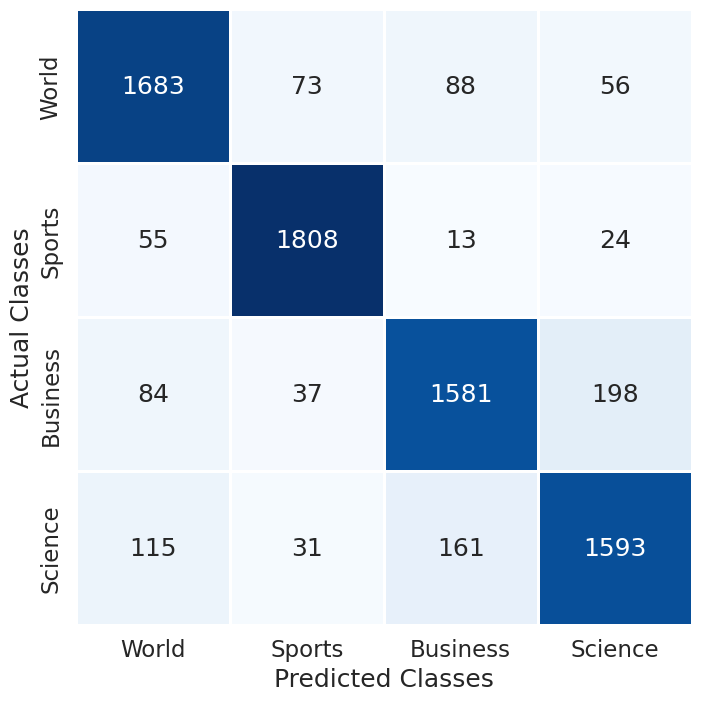

In [27]:
eval_model(test_y,pred)

c=round(accuracy_score(test_y,pred)*100,3)

confusion_mat('Blues')

## Uni-gram + Bi-gram + Tri-gram

In [28]:
tfidf = TfidfVectorizer(
    min_df=8,
    ngram_range=(1, 3)
)

train_arr = tfidf.fit_transform(train_x)
test_arr  = tfidf.transform(test_x)

total_features = train_arr.shape[1]

print("No. of features extracted (TF-IDF):", total_features)
print("First 100 feature names:")
print(list(tfidf.vocabulary_.keys())[:100])


print(f"Total features: {total_features}")

No. of features extracted (TF-IDF): 71656
First 100 feature names:
['wall', 'st', 'bear', 'claw', 'back', 'black', 'reuter', 'short', 'seller', 'street', 'dwindl', 'band', 'ultra', 'cynic', 'see', 'green', 'wall st', 'claw back', 'back black', 'reuter reuter', 'wall street', 'see green', 'carlyl', 'look', 'toward', 'commerci', 'aerospac', 'privat', 'invest', 'firm', 'group', 'reput', 'make', 'well', 'time', 'occasion', 'controversi', 'play', 'defens', 'industri', 'quietli', 'place', 'bet', 'anoth', 'part', 'market', 'reuter privat', 'privat invest', 'invest firm', 'carlyl group', 'play defens', 'place bet', 'oil', 'economi', 'cloud', 'stock', 'outlook', 'soar', 'crude', 'price', 'plu', 'worri', 'earn', 'expect', 'hang', 'next', 'week', 'depth', 'summer', 'doldrum', 'oil economi', 'outlook reuter', 'soar crude', 'crude price', 'worri economi', 'economi outlook', 'earn expect', 'hang stock', 'stock market', 'market next', 'next week', 'outlook reuter reuter', 'iraq', 'halt', 'export', 'm

In [29]:
print("Đang thực hiện Grid Search...")
grid_search.fit(train_arr, train_y)

# ==============================================================================
# 4. XUẤT KẾT QUẢ CHI TIẾT (KHÔNG LÀM TRÒN)
# ==============================================================================
cv_results = pd.DataFrame(grid_search.cv_results_)

# Lấy các cột quan trọng
results_summary = cv_results[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]

# Đổi tên cột
results_summary.columns = ['Tham số', 'Độ chính xác TB', 'Độ lệch chuẩn', 'Xếp hạng']

# Sắp xếp theo xếp hạng
results_summary = results_summary.sort_values(by='Xếp hạng')

# --- QUAN TRỌNG: ĐỊNH DẠNG HIỂN THỊ ---
# Dùng style.format để hiển thị 6 chữ số thập phân
print("\n--- BẢNG KẾT QUẢ CHI TIẾT ---")
try:
    # Hiển thị đẹp nếu chạy trong Jupyter Notebook
    display(results_summary.style.format({
        'Độ chính xác TB': '{:.6f}',
        'Độ lệch chuẩn': '{:.6f}'
    }))
except NameError:
    # Fallback nếu không có hàm display (chạy terminal)
    print(results_summary.to_string(formatters={
        'Độ chính xác TB': '{:.6f}'.format,
        'Độ lệch chuẩn': '{:.6f}'.format
    }))

# 4. In kết quả tốt nhất
print(f"Tham số tốt nhất: {grid_search.best_params_}")
print(f"Độ chính xác tốt nhất trên tập Validation: {grid_search.best_score_:.4f}")

# 5. Gán mô hình tốt nhất vào biến NB_MN để dùng tiếp cho các đoạn code đánh giá bên dưới
NB_MN = grid_search.best_estimator_
# NB_MN = MultinomialNB()
# NB_MN.fit(train_arr,train_y)
# 6. Dự đoán trên tập test
pred = NB_MN.predict(test_arr)

print("first 20 actual labels")
print(test_y.tolist()[:20])
print("first 20 predicted labels")
print(pred.tolist()[:20])

Đang thực hiện Grid Search...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

--- BẢNG KẾT QUẢ CHI TIẾT ---


,Tham số,Độ chính xác TB,Độ lệch chuẩn,Xếp hạng
3,{'alpha': 0.5},0.901167,0.008970,1
2,{'alpha': 0.1},0.901150,0.008957,2
4,{'alpha': 1.0},0.900792,0.008500,3
5,{'alpha': 2.0},0.899725,0.008553,4
1,{'alpha': 0.01},0.898700,0.009138,5
6,{'alpha': 5.0},0.897475,0.008531,6
0,{'alpha': 0.001},0.894967,0.009645,7
7,{'alpha': 10.0},0.894892,0.008798,8


Tham số tốt nhất: {'alpha': 0.5}
Độ chính xác tốt nhất trên tập Validation: 0.9012
first 20 actual labels
[3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
first 20 predicted labels
[3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3]


Test set accuracy: 0.9016
Test set precision: 0.9014
Test set recall: 0.9016
Test set F1: 0.9012
F1 per class: [0.90438034 0.96303955 0.86189327 0.8755832 ]


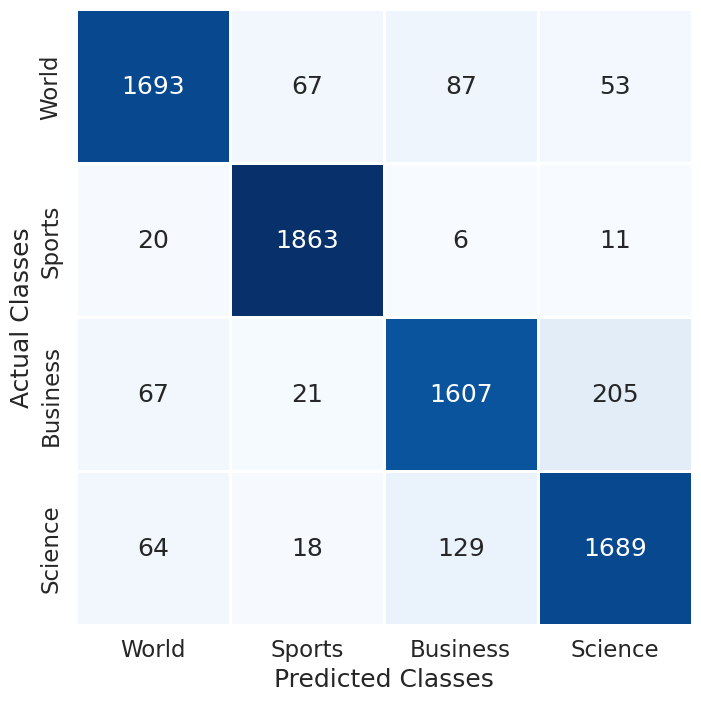

In [30]:
eval_model(test_y,pred)

c=round(accuracy_score(test_y,pred)*100,3)

confusion_mat('Blues')

## Uni-gram + Bi-gram + Tri-gram (default smoothing)

first 20 actual labels
[3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
first 20 predicted labels
[3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3]
Test set accuracy: 0.9022
Test set precision: 0.9019
Test set recall: 0.9022
Test set F1: 0.9019
F1 per class: [0.90589176 0.96231285 0.86288163 0.87633429]


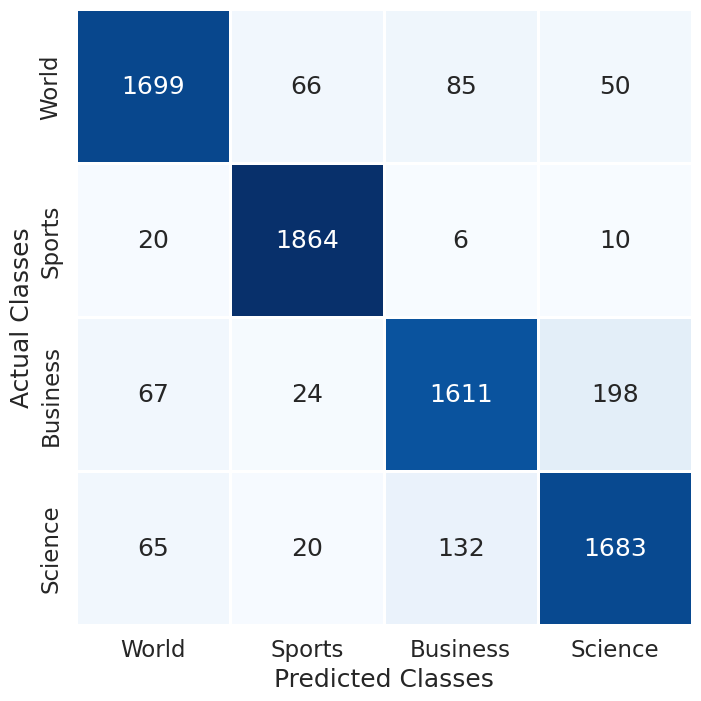

In [31]:
NB_MN = MultinomialNB()
NB_MN.fit(train_arr,train_y)

pred = NB_MN.predict(test_arr)

print("first 20 actual labels")
print(test_y.tolist()[:20])
print("first 20 predicted labels")
print(pred.tolist()[:20])
eval_model(test_y,pred)

c=round(accuracy_score(test_y,pred)*100,3)

confusion_mat('Blues')

In [32]:
# ==============================================================================
# TRÍCH XUẤT VÀ HIỂN THỊ MẪU DỰ ĐOÁN (QUALITATIVE ANALYSIS)
# ==============================================================================

# 1. Tạo DataFrame tạm thời chứa Text gốc, Nhãn thực tế và Nhãn dự đoán
# Lưu ý: Dùng .values để đảm bảo index khớp nhau giữa các biến
results_df = pd.DataFrame({
    'Text': test_x.values,
    'Actual': test_y.values,
    'Predicted': pred
})

# 2. Tách riêng tập dự đoán ĐÚNG và dự đoán SAI
correct_cases = results_df[results_df['Actual'] == results_df['Predicted']]
incorrect_cases = results_df[results_df['Actual'] != results_df['Predicted']]

# 3. Hàm in kết quả đẹp mắt
def print_samples(title, data_df, n=3):
    print(f"\n{'='*30}")
    print(f"  {title}")
    print(f"{'='*30}")
    
    if data_df.empty:
        print("Không có dữ liệu cho trường hợp này.")
        return
    
    # Lấy ngẫu nhiên n mẫu (nếu số lượng ít hơn n thì lấy hết)
    samples = data_df.sample(n=min(n, len(data_df)), random_state=42) # random_state để cố định kết quả nếu cần
    
    for idx, row in enumerate(samples.itertuples(), 1):
        print(f"\n>> MẪU {idx}:")
        print(f"📝 Nội dung (200 ký tự đầu): {row.Text[:200]}...") 
        print(f"✅ Nhãn Thực tế : {row.Actual}")
        print(f"🤖 Nhãn Dự đoán : {row.Predicted}")
        print("-" * 50)

# 4. Thực thi
print(f"Tổng số câu đúng: {len(correct_cases)}")
print(f"Tổng số câu sai: {len(incorrect_cases)}")

print_samples("3 KẾT QUẢ DỰ ĐOÁN ĐÚNG (CORRECT)", correct_cases, n=3)
print_samples("3 KẾT QUẢ DỰ ĐOÁN SAI (INCORRECT)", incorrect_cases, n=3)

Tổng số câu đúng: 6857
Tổng số câu sai: 743

  3 KẾT QUẢ DỰ ĐOÁN ĐÚNG (CORRECT)

>> MẪU 1:
📝 Nội dung (200 ký tự đầu): cisco reach high low new york cisco system aggress tri build presenc key growth market  use new product new acquisit...
✅ Nhãn Thực tế : 4
🤖 Nhãn Dự đoán : 4
--------------------------------------------------

>> MẪU 2:
📝 Nội dung (200 ký tự đầu): ca buy netegr  biggest acquisit sinc  mark return inorgan growth mode shelv acquisit plan due govern probe account practic...
✅ Nhãn Thực tế : 3
🤖 Nhãn Dự đoán : 3
--------------------------------------------------

>> MẪU 3:
📝 Nội dung (200 ký tự đầu): musharraf visit afghanistan pakistani presid gener pervez musharraf visit landmark presidenti poll afghanistan congratul afghan counterpart hamid karzai victori saturday afternoon...
✅ Nhãn Thực tế : 1
🤖 Nhãn Dự đoán : 1
--------------------------------------------------

  3 KẾT QUẢ DỰ ĐOÁN SAI (INCORRECT)

>> MẪU 1:
📝 Nội dung (200 ký tự đầu): congress send net access ban wh

# For visualizing calculation only

In [33]:
import pandas as pd
import numpy as np
import html
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from IPython.display import display, HTML

# 1. HÀM TIỀN XỬ LÝ
def full_preprocessing(text):
    text = html.unescape(text)
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    words = re.findall(r"[\w']+", text.lower())
    stop_words_set = set(stopwords.words('english'))
    words = [w for w in words if w not in stop_words_set]
    words = [''.join(c for c in w if c not in string.punctuation) for w in words]
    words = [''.join(c for c in w if c not in string.digits) for w in words]
    stemmer = PorterStemmer()
    words = [stemmer.stem(w) for w in words]
    extra_trash = ['href', 'lt', 'gt', 'ii', 'iii', 'ie', 'quot', 'com']
    words = [w for w in words if w and w not in extra_trash]
    return " ".join(words)

# 2. TÍNH TOÁN
raw_text = "Comets, Asteroids and Planets around a Nearby Star SPACE.com - A nearby star thought to harbor comets and asteroids now appears to be home to planets, too. The presumed worlds are smaller than Jupiter and could be as tiny as Pluto, new observations suggest."
class_labels = ['World', 'Sports', 'Business', 'Sci/Tech']

cleaned_text = full_preprocessing(raw_text)
vec = tfidf.transform([cleaned_text])
indices = vec.nonzero()[1]
feature_names = tfidf.get_feature_names_out()

model_log_likelihood = NB_MN.feature_log_prob_ 
model_log_prior = NB_MN.class_log_prior_

data = []
for idx in indices:
    row = {}
    x_i = vec[0, idx]
    token = feature_names[idx]
    
    # Cột 1: Feature
    row['Feature (w)'] = token
    
    # Cột 2: TF-IDF (x_i)
    row['x_i'] = x_i
    
    for k, label in enumerate(class_labels):
        # Log P(w|C)
        log_prob_w_given_c = model_log_likelihood[k][idx]
        
        # Log P(w^x_i | C) = x_i * Log P(w|C)
        weighted_log_prob = x_i * log_prob_w_given_c
        
        # TÊN CỘT CHUẨN TOÁN HỌC
        row[f'Log P(w|{label})'] = log_prob_w_given_c
        row[f'xi·LogP(w|{label})'] = weighted_log_prob  # <--- ĐỔI TÊN Ở ĐÂY
        
    data.append(row)

df = pd.DataFrame(data).sort_values(by='x_i', ascending=False).reset_index(drop=True)

# 3. HIỂN THỊ
style = """<style>
.scroll-box { max_height: 500px; overflow_y: auto; border: 1px solid #ccc; } 
.scroll-box thead th { position: sticky; top: 0; background: #e9ecef; z-index: 1; text-align: center; }
</style>"""

print("BẢNG PHÂN RÃ HÀM HỢP LÝ LOG-LIKELIHOOD (KÝ HIỆU CHUẨN):")
print("• x_i: Cường độ xuất hiện của từ (TF-IDF)")
print("• Log P(w|C): Xác suất của từ trong lớp C")
print("• xi·LogP(w|C): Log xác suất có trọng số (Phần đóng góp thực tế)")
display(HTML(style))
display(HTML(f"<div class='scroll-box'>{df.to_html(classes='table table-sm table-bordered', float_format='{:,.4f}'.format)}</div>"))

BẢNG PHÂN RÃ HÀM HỢP LÝ LOG-LIKELIHOOD (KÝ HIỆU CHUẨN):
• x_i: Cường độ xuất hiện của từ (TF-IDF)
• Log P(w|C): Xác suất của từ trong lớp C
• xi·LogP(w|C): Log xác suất có trọng số (Phần đóng góp thực tế)


,Feature (w),x_i,Log P(w|World),xi·LogP(w|World),Log P(w|Sports),xi·LogP(w|Sports),Log P(w|Business),xi·LogP(w|Business),Log P(w|Sci/Tech),xi·LogP(w|Sci/Tech)
0,nearbi star,0.4330,-12.1962,-5.2804,-12.3059,-5.3279,-12.3554,-5.3493,-11.2830,-4.8850
1,asteroid,0.3639,-11.9895,-4.3632,-12.3059,-4.4783,-12.3554,-4.4964,-9.5392,-3.4715
2,comet,0.3598,-12.3434,-4.4415,-11.2585,-4.0511,-12.3554,-4.4459,-9.5106,-3.4222
3,nearbi,0.3366,-10.0016,-3.3669,-11.1864,-3.7658,-11.6099,-3.9084,-10.6806,-3.5955
4,planet,0.2817,-10.8098,-3.0456,-11.2972,-3.1829,-12.0127,-3.3845,-8.0645,-2.2721
5,star,0.2227,-9.0621,-2.0177,-7.5068,-1.6714,-9.6067,-2.1390,-8.4896,-1.8903
6,new observ,0.2105,-12.3434,-2.5988,-12.3059,-2.5909,-12.3554,-2.6014,-11.0288,-2.3221
7,presum,0.1931,-10.8830,-2.1012,-11.5363,-2.2273,-11.8915,-2.2959,-11.4008,-2.2012
8,harbor,0.1815,-11.3245,-2.0558,-10.9209,-1.9825,-11.9569,-2.1706,-10.6774,-1.9383
9,jupit,0.1811,-12.3434,-2.2356,-12.3059,-2.2288,-11.8479,-2.1459,-9.7297,-1.7622


In [34]:
import numpy as np

# Chọn từ bạn muốn kiểm tra (phải là từ có trong bảng kết quả bên trên, ví dụ 'comet', 'space'...)
# Lưu ý: Từ này phải là từ gốc sau khi stemming (ví dụ 'observ' thay vì 'observations')
target_word = "comet" 

if target_word in tfidf.vocabulary_:
    # 1. LẤY CÁC THAM SỐ GỐC TỪ MODEL
    idx = tfidf.vocabulary_[target_word]   # Index của từ trong từ điển
    alpha = NB_MN.alpha                    # Hệ số làm trơn (Smoothing)
    V = NB_MN.feature_log_prob_.shape[1]   # Tổng số từ vựng (Vocabulary Size)
    
    print(f"=== GIẢI MÃ CÁCH TÍNH W CHO TỪ: '{target_word.upper()}' ===")
    print(f"• Công thức Naive Bayes: P(w|c) = (Tổng điểm từ trong lớp + alpha) / (Tổng điểm cả lớp + alpha * V)")
    print(f"• W = Log(P(w|c))")
    print(f"• Tham số cố định: Alpha = {alpha}, V = {V}")
    print("-" * 80)

    class_labels = ['World', 'Sports', 'Business', 'Sci/Tech']
    
    # 2. TÍNH TOÁN CHO TỪNG LỚP
    for i, label in enumerate(class_labels):
        # A. Lấy dữ liệu thô từ bộ nhớ model
        # feature_count_[i, idx]: Tổng giá trị TF-IDF của từ này trong tất cả bài viết thuộc lớp i
        count_word = NB_MN.feature_count_[i, idx] 
        
        # feature_count_[i].sum(): Tổng giá trị TF-IDF của TẤT CẢ các từ trong lớp i
        count_class = NB_MN.feature_count_[i].sum()
        
        # B. Áp dụng công thức (Tính tay)
        numerator = count_word + alpha                  # Tử số
        denominator = count_class + (alpha * V)         # Mẫu số
        probability = numerator / denominator           # Xác suất P(w|c)
        w_manual = np.log(probability)                  # Log Prob (W)
        
        # C. Lấy giá trị có sẵn trong model để đối chiếu
        w_model = NB_MN.feature_log_prob_[i, idx]
        
        # D. In kết quả
        print(f"LỚP [{label}]:")
        print(f"   1. Tổng điểm từ '{target_word}' trong lớp : {count_word:10.4f}")
        print(f"   2. Tổng điểm của cả lớp {label:<10}    : {count_class:10.4f}")
        print(f"   3. Xác suất = ({count_word:.2f} + {alpha}) / ({count_class:.2f} + {alpha} * {V})")
        print(f"               = {numerator:.4f} / {denominator:.4f} = {probability:.10f}")
        print(f"   4. W (Tính tay) = Log({probability:.10f}) = {w_manual:.4f}")
        print(f"      W (Model)    = {w_model:.4f}  {'✅ KHỚP' if np.isclose(w_manual, w_model) else '❌ SAI'}")
        print("-" * 80)

else:
    print(f"Lỗi: Từ '{target_word}' không có trong bộ từ điển của mô hình (có thể đã bị lọc bỏ hoặc bạn viết sai chính tả).")
    print("Gợi ý: Hãy thử các từ như 'observ', 'presum', 'planet'...")

=== GIẢI MÃ CÁCH TÍNH W CHO TỪ: 'COMET' ===
• Công thức Naive Bayes: P(w|c) = (Tổng điểm từ trong lớp + alpha) / (Tổng điểm cả lớp + alpha * V)
• W = Log(P(w|c))
• Tham số cố định: Alpha = 1.0, V = 71656
--------------------------------------------------------------------------------
LỚP [World]:
   1. Tổng điểm từ 'comet' trong lớp :     0.0000
   2. Tổng điểm của cả lớp World         : 157781.9955
   3. Xác suất = (0.00 + 1.0) / (157782.00 + 1.0 * 71656)
               = 1.0000 / 229437.9955 = 0.0000043585
   4. W (Tính tay) = Log(0.0000043585) = -12.3434
      W (Model)    = -12.3434  ✅ KHỚP
--------------------------------------------------------------------------------
LỚP [Sports]:
   1. Tổng điểm từ 'comet' trong lớp :     1.8502
   2. Tổng điểm của cả lớp Sports        : 149333.8079
   3. Xác suất = (1.85 + 1.0) / (149333.81 + 1.0 * 71656)
               = 2.8502 / 220989.8079 = 0.0000128976
   4. W (Tính tay) = Log(0.0000128976) = -11.2585
      W (Model)    = -11.2585  ✅ KHỚP

In [35]:
import pandas as pd
import html
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# ==============================================================================
# 1. HÀM TIỀN XỬ LÝ (Chuẩn hóa + Stemming)
# ==============================================================================
def full_preprocessing(text):
    text = html.unescape(text)
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    words = re.findall(r"[\w']+", text.lower())
    
    stop_words_set = set(stopwords.words('english'))
    words = [w for w in words if w not in stop_words_set]
    words = [''.join(c for c in w if c not in string.punctuation) for w in words]
    words = [''.join(c for c in w if c not in string.digits) for w in words]
    
    # Stemming (Quan trọng)
    stemmer = PorterStemmer()
    words = [stemmer.stem(w) for w in words]
    
    extra_trash = ['href', 'lt', 'gt', 'ii', 'iii', 'ie', 'quot', 'com']
    words = [w for w in words if w and w not in extra_trash]
    return " ".join(words)

# ==============================================================================
# 2. XỬ LÝ & TẠO BẢNG
# ==============================================================================
text = "Comets, Asteroids and Planets around a Nearby Star SPACE.com - A nearby star thought to harbor comets and asteroids now appears to be home to planets, too. The presumed worlds are smaller than Jupiter and could be as tiny as Pluto, new observations suggest."

# Làm sạch
cleaned_text = full_preprocessing(text)
print(f"Văn bản sau xử lý: {cleaned_text}\n")

# Tính TF-IDF
vec = tfidf.transform([cleaned_text])
indices = vec.nonzero()[1]
feature_names = tfidf.get_feature_names_out()

# Tạo dữ liệu
data = []
for idx in indices:
    data.append({
        'Feature': feature_names[idx],
        'TF-IDF': vec[0, idx]
    })

# Tạo DataFrame & Sắp xếp
df_tfidf = pd.DataFrame(data)
df_tfidf = df_tfidf.sort_values(by='TF-IDF', ascending=False)

# ===> ĐIỀU CHỈNH INDEX: Reset lại từ 0 đến 19 <===
df_tfidf = df_tfidf.reset_index(drop=True)

# Hiển thị
print("BẢNG TOKEN & TF-IDF (Đã sắp xếp):")
display(df_tfidf)

Văn bản sau xử lý: comet asteroid planet around nearbi star space nearbi star thought harbor comet asteroid appear home planet presum world smaller jupit could tini pluto new observ suggest

BẢNG TOKEN & TF-IDF (Đã sắp xếp):


,Feature,TF-IDF
0,nearbi star,0.432954
1,asteroid,0.363917
2,comet,0.359830
3,nearbi,0.336640
4,planet,0.281746
5,star,0.222656
6,new observ,0.210545
7,presum,0.193073
8,harbor,0.181533
9,jupit,0.181117


In [36]:
import numpy as np
import pandas as pd
from IPython.display import display, HTML

# ==============================================================================
# CẤU HÌNH: CHỌN TỪ CẦN KIỂM TRA
# ==============================================================================
target_token = "comet"  # Lưu ý: Phải là từ đã qua Stemming (ví dụ 'observ' thay vì 'observations')
# Nếu không tìm thấy, hãy thử đổi thành 'asteroid', 'space', 'planet'...

# Kiểm tra xem từ này có trong từ điển không
if target_token not in tfidf.vocabulary_:
    print(f"❌ Lỗi: Từ '{target_token}' không tồn tại trong bộ từ điển của mô hình.")
else:
    # 1. LẤY DỮ LIỆU ĐẦU VÀO
    # --------------------------------------------------------------------------
    idx = tfidf.vocabulary_[target_token]   # Vị trí index của từ
    alpha = NB_MN.alpha                     # Hệ số làm trơn (thường là 1.0)
    V = NB_MN.feature_count_.shape[1]       # Tổng số từ vựng (|V| = 9914)
    
    # Lấy giá trị TF-IDF (x_i) của từ này trong câu văn bản mẫu
    # (Giả sử bạn đã chạy vec = tfidf.transform([cleaned_text]) ở các bước trước)
    x_i = vec[0, idx]
    
    print(f"MAGNIFYING GLASS: PHÂN TÍCH TỪ '{target_token.upper()}'")
    print("=" * 80)
    print(f"• Cường độ xuất hiện trong câu (x_i): {x_i:.4f}")
    print(f"• Tổng số từ vựng (|V|): {V}")
    print(f"• Hệ số làm trơn Alpha (α): {alpha}")
    print("=" * 80)
    print(f"{'LỚP (CLASS)':<15} | {'BƯỚC 1: TỬ SỐ':<20} | {'BƯỚC 2: MẪU SỐ':<20} | {'BƯỚC 3: XÁC SUẤT P(w|C)':<25} | {'BƯỚC 4: LOG P (W)':<20} | {'BƯỚC 5: CONTRIB':<20}")
    print("-" * 130)

    # 2. TÍNH TOÁN CHI TIẾT TỪNG LỚP
    # --------------------------------------------------------------------------
    class_labels = ['World', 'Sports', 'Business', 'Sci/Tech']
    
    for i, label in enumerate(class_labels):
        # A. LẤY SỐ LIỆU THÔ TỪ MODEL
        # N_wc: Tổng điểm TF-IDF của từ 'comet' trong toàn bộ lớp C
        N_wc = NB_MN.feature_count_[i, idx]
        
        # N_c: Tổng điểm TF-IDF của TẤT CẢ các từ trong lớp C
        N_c = NB_MN.feature_count_[i].sum()
        
        # B. TÍNH TOÁN THEO CÔNG THỨC
        # Bước 1: Tử số (Numerator) = N_wc + alpha
        numerator = N_wc + alpha
        
        # Bước 2: Mẫu số (Denominator) = N_c + (alpha * V)
        denominator = N_c + (alpha * V)
        
        # Bước 3: Xác suất P(w|C) = Tử / Mẫu
        prob = numerator / denominator
        
        # Bước 4: Log Likelihood = ln(prob)
        log_prob = np.log(prob)
        
        # Bước 5: Contribution = x_i * Log Likelihood
        contribution = x_i * log_prob
        
        # In ra dòng kết quả
        print(f"{label:<15} | {N_wc:8.2f} + {alpha}         | {N_c:8.0f} + {V}       | {numerator:.2f}/{denominator:.0f} = {prob:.8f}  | ln({prob:.6f}) = {log_prob:6.2f} | {x_i:.2f} * {log_prob:.2f} = {contribution:6.2f}")

    print("-" * 130)
    print("GIẢI THÍCH Ý NGHĨA:")
    print("1. Tử số (N_wc + α): Số lần mô hình 'gặp' từ này trong lớp đó (cộng 1 lần giả định).")
    print("2. Mẫu số (N_c + αV): Tổng dung lượng kiến thức của lớp đó.")
    print("3. P(w|C): Tỷ lệ xuất hiện của từ (Độ phổ biến).")
    print("4. Log P: Chuyển sang thang đo Logarit (Số âm, càng gần 0 càng tốt).")
    print("5. Contrib: Điểm số thực tế được cộng vào tổng điểm cuối cùng.")

MAGNIFYING GLASS: PHÂN TÍCH TỪ 'COMET'
• Cường độ xuất hiện trong câu (x_i): 0.3598
• Tổng số từ vựng (|V|): 71656
• Hệ số làm trơn Alpha (α): 1.0
LỚP (CLASS)     | BƯỚC 1: TỬ SỐ        | BƯỚC 2: MẪU SỐ       | BƯỚC 3: XÁC SUẤT P(w|C)   | BƯỚC 4: LOG P (W)    | BƯỚC 5: CONTRIB     
----------------------------------------------------------------------------------------------------------------------------------
World           |     0.00 + 1.0         |   157782 + 71656       | 1.00/229438 = 0.00000436  | ln(0.000004) = -12.34 | 0.36 * -12.34 =  -4.44
Sports          |     1.85 + 1.0         |   149334 + 71656       | 2.85/220990 = 0.00001290  | ln(0.000013) = -11.26 | 0.36 * -11.26 =  -4.05
Business        |     0.00 + 1.0         |   160566 + 71656       | 1.00/232222 = 0.00000431  | ln(0.000004) = -12.36 | 0.36 * -12.36 =  -4.45
Sci/Tech        |    15.29 + 1.0         |   148232 + 71656       | 16.29/219888 = 0.00007406  | ln(0.000074) =  -9.51 | 0.36 * -9.51 =  -3.42
--------------

In [37]:
import pandas as pd
import numpy as np
from IPython.display import display

# Lấy dữ liệu từ mô hình đã train
data = {
    'Lớp (Class)': NB_MN.classes_,
    'Số bài đã học (Count)': NB_MN.class_count_,
    'Tỷ lệ % (Probability)': np.exp(NB_MN.class_log_prior_) * 100,
    'Điểm Ưu Tiên (Log Prior)': NB_MN.class_log_prior_
}

df_priors = pd.DataFrame(data)

# Sắp xếp cho dễ nhìn
df_priors = df_priors.sort_values(by='Điểm Ưu Tiên (Log Prior)', ascending=False)

print("=== BẢNG ĐIỂM ƯU TIÊN (LOG PRIOR) ===")
display(df_priors)

=== BẢNG ĐIỂM ƯU TIÊN (LOG PRIOR) ===


,Lớp (Class),Số bài đã học (Count),Tỷ lệ % (Probability),Điểm Ưu Tiên (Log Prior)
0,1,30000.0,25.0,-1.386294
1,2,30000.0,25.0,-1.386294
2,3,30000.0,25.0,-1.386294
3,4,30000.0,25.0,-1.386294


Tổng số dòng dữ liệu: 120000

=== [1] PHÂN PHỐI TOÀN BỘ DỮ LIỆU GỐC (120k) ===
    Số lượng  Tỷ lệ %
ID                   
1      30000     25.0
2      30000     25.0
3      30000     25.0
4      30000     25.0

=== [2] PHÂN PHỐI TẬP TRAIN THỰC TẾ (60k dòng đầu) ===
    Số lượng    Tỷ lệ %
ID                     
1      15513  25.855000
2      14701  24.501667
3      14440  24.066667
4      15346  25.576667


/tmp/ipykernel_55/801709337.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=full_counts.index, y=full_counts.values, ax=axes[0], palette='viridis')
/tmp/ipykernel_55/801709337.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=subset_counts.index, y=subset_counts.values, ax=axes[1], palette='magma')


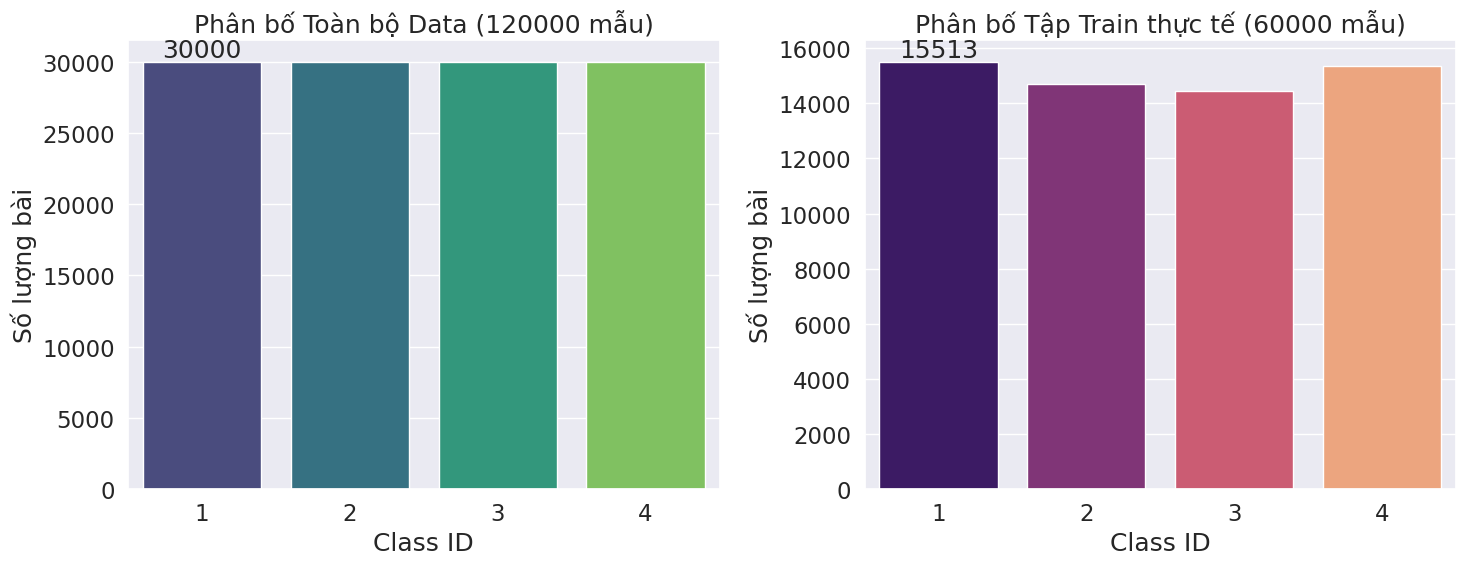

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Giả sử bạn đã load dữ liệu vào biến 'train_data' như trong code cũ
# Nếu chưa thì uncomment dòng dưới:
# train_data = pd.read_csv('path/to/train.csv')

print(f"Tổng số dòng dữ liệu: {len(train_data)}")

# ==============================================================================
# 1. KIỂM TRA PHÂN PHỐI TOÀN BỘ (120.000 DÒNG)
# ==============================================================================
print("\n=== [1] PHÂN PHỐI TOÀN BỘ DỮ LIỆU GỐC (120k) ===")
full_counts = train_data['ID'].value_counts().sort_index()
full_ratio = train_data['ID'].value_counts(normalize=True).sort_index() * 100

df_full = pd.DataFrame({'Số lượng': full_counts, 'Tỷ lệ %': full_ratio})
print(df_full)

# ==============================================================================
# 2. KIỂM TRA PHÂN PHỐI TẬP TRAIN BẠN ĐANG DÙNG (60.000 DÒNG ĐẦU)
# ==============================================================================
# Code cũ của bạn là: train_y = train_data.ID[:60000]
subset_labels = train_data['ID'][:60000]

print("\n=== [2] PHÂN PHỐI TẬP TRAIN THỰC TẾ (60k dòng đầu) ===")
subset_counts = subset_labels.value_counts().sort_index()
subset_ratio = subset_labels.value_counts(normalize=True).sort_index() * 100

df_subset = pd.DataFrame({'Số lượng': subset_counts, 'Tỷ lệ %': subset_ratio})
print(df_subset)

# ==============================================================================
# 3. VẼ BIỂU ĐỒ SO SÁNH TRỰC QUAN
# ==============================================================================
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Biểu đồ 1: Toàn bộ dữ liệu
sns.barplot(x=full_counts.index, y=full_counts.values, ax=axes[0], palette='viridis')
axes[0].set_title(f'Phân bố Toàn bộ Data ({len(train_data)} mẫu)')
axes[0].set_xlabel('Class ID')
axes[0].set_ylabel('Số lượng bài')
axes[0].bar_label(axes[0].containers[0])

# Biểu đồ 2: Tập cắt 60k
sns.barplot(x=subset_counts.index, y=subset_counts.values, ax=axes[1], palette='magma')
axes[1].set_title(f'Phân bố Tập Train thực tế ({len(subset_labels)} mẫu)')
axes[1].set_xlabel('Class ID')
axes[1].set_ylabel('Số lượng bài')
axes[1].bar_label(axes[1].containers[0])

plt.tight_layout()
plt.show()

# Predicting on Another Dataset

In [39]:
import json
def load_json_to_df(file_path):
    # lines=True cho phép đọc file có nhiều object JSON (mỗi dòng 1 object)
    df = pd.read_json(file_path, lines=True)
    
    # Nếu dữ liệu bên trong vẫn bị bọc bởi cột 'root', ta làm phẳng nó
    if 'root' in df.columns:
        # Chuyển đổi cột root (đang là dict) thành các cột riêng biệt
        root_df = pd.json_normalize(df['root'])
        return root_df
        
    return df

# Sử dụng:
train_data = load_json_to_df('/kaggle/input/more-data/bbc_news.json')
print(train_data['label_text'].unique())

['entertainment' 'sport' 'business' 'politics' 'tech']


Đang tính toán thống kê...

==================== BẢNG THỐNG KÊ ĐẦY ĐỦ ====================


Train  Whole Dataset
Len: Text mean  384.5          384.5
          min   116.0          116.0
          max  3007.0         3007.0

/tmp/ipykernel_55/3222985921.py:52: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


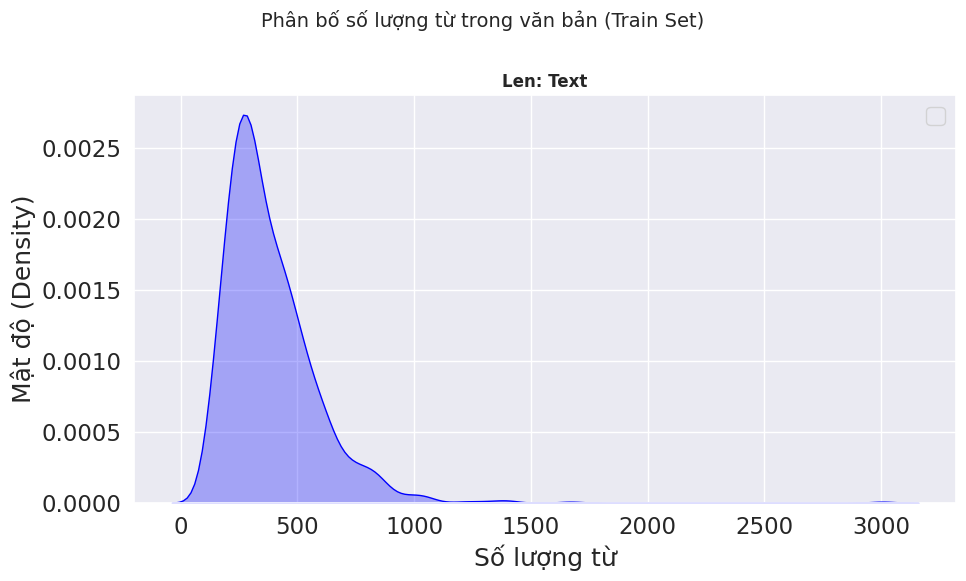

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. CHIA TẬP DỮ LIỆU
train_subset = train_data.copy()

# 2. GỘP DỮ LIỆU ĐỂ TÍNH TOÁN
df_all = pd.concat([
    train_subset.assign(Dataset='Train'),
], ignore_index=True)

# 3. TÍNH TOÁN CHỈ SỐ
print("Đang tính toán thống kê...")
df_all['Len: Text'] = df_all['text'].apply(lambda x: len(str(x).split()))

# 4. TẠO BẢNG THỐNG KÊ
metrics = ['Len: Text']
stats_by_group = df_all.groupby('Dataset')[metrics].agg(['mean', 'min', 'max'])
stats_total = df_all[metrics].agg(['mean', 'min', 'max']).unstack().to_frame().T
stats_total.columns = stats_by_group.columns
stats_total.index = ['Whole Dataset']

final_stats = pd.concat([stats_by_group, stats_total])
pd.options.display.float_format = '{:.1f}'.format 

print("\n" + "="*20 + " BẢNG THỐNG KÊ ĐẦY ĐỦ " + "="*20)
display(final_stats.T)

# 5. VẼ BIỂU ĐỒ (Chỉ 1 biểu đồ cho Train)
# Chỉnh figsize nhỏ lại vì chỉ có 1 biểu đồ, và nrows=1, ncols=1
fig, ax = plt.subplots(figsize=(10, 6)) 
fig.suptitle('Phân bố số lượng từ trong văn bản (Train Set)', fontsize=14)

# Vẽ biểu đồ KDE
sns.kdeplot(
    data=df_all[df_all['Dataset'] == 'Train'], 
    x='Len: Text', 
    fill=True, 
    color='blue', 
    alpha=0.3, 
    ax=ax
)

# Thêm các đường thống kê để biểu đồ trực quan hơn
mean_val = df_all['Len: Text'].mean()
# ax.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.1f}')

ax.set_title('Len: Text', fontsize=12, fontweight='bold')
ax.set_xlabel('Số lượng từ')
ax.set_ylabel('Mật độ (Density)')
ax.legend()

plt.tight_layout()
plt.show()

In [45]:
csv_file_path = '/kaggle/input/another-news-data/summarized_data.csv'  # <-- Thay tên file của bạn vào đây
col_text_full = 'text'                   # <-- Tên cột chứa văn bản gốc
col_text_summary = 'summarized_text'     # <-- Tên cột chứa văn bản tóm tắt

# 2. Load dữ liệu
print(f"Đang đọc file {csv_file_path}...")
df_new = pd.read_csv(csv_file_path)

# ==============================================================================
# BƯỚC 3: TIỀN XỬ LÝ (PREPROCESSING)
# =Phải chạy lại các bước làm sạch giống hệt lúc train=
# Giả sử bạn đã định nghĩa các hàm này ở trên: clean_html_noise, url_remove, v.v.
# ==============================================================================

def apply_preprocessing(text_series):
    # Copy lại quy trình bạn đã làm với tập Train
    # Lưu ý: Đảm bảo các hàm clean_html_noise... đã được define ở các cell trên
    step1 = text_series.apply(clean_html_noise)
    step2 = step1.apply(url_remove)
    step3 = step2.apply(word_tokenize)
    step4 = step3.apply(lambda x: [word.lower() for word in x])
    step5 = step4.apply(remove_stopwords)
    step6 = step5.apply(remove_punctuations)
    step7 = step6.apply(remove_number)
    step8 = step7.apply(stemming)
    step9 = step8.apply(remove_extra_words)
    step10 = step9.apply(join_words_with_space)
    return step10 

Đang đọc file /kaggle/input/another-news-data/summarized_data.csv...


In [46]:
print("Đang tiền xử lý dữ liệu...")
# Xử lý cho cả 2 cột
df_new['clean_full'] = apply_preprocessing(df_new[col_text_full])
df_new['clean_summary'] = apply_preprocessing(df_new[col_text_summary])

# ==============================================================================
# BƯỚC 4: VECTOR HÓA (VECTORIZATION)
# =QUAN TRỌNG: Dùng .transform(), TUYỆT ĐỐI KHÔNG dùng .fit_transform()=
# ==============================================================================
print("Đang vector hóa dữ liệu...")

# Biến đổi văn bản thành số dựa trên bộ từ điển đã học từ tập Train
X_new_full = tfidf.transform(df_new['clean_full'])
X_new_summary = tfidf.transform(df_new['clean_summary'])

# ==============================================================================
# BƯỚC 5: DỰ ĐOÁN (PREDICT)
# ==============================================================================
print("Đang dự đoán...")

# Dự đoán trên Text gốc
pred_full = NB_MN.predict(X_new_full)

# Dự đoán trên Text tóm tắt
pred_summary = NB_MN.predict(X_new_summary)

# ==============================================================================
# BƯỚC 6: LƯU KẾT QUẢ
# ==============================================================================
# Gán kết quả vào DataFrame
df_new['prediction_full'] = pred_full
df_new['prediction_summary'] = pred_summary

# Nếu muốn lấy lại tên nhãn thay vì số (nếu model trả ra số)
# df_new['label_name_full'] = [class_names[i] for i in pred_full] 

print("Hoàn tất! Hiển thị 5 dòng kết quả đầu tiên:")
display(df_new[[col_text_full, 'prediction_full', col_text_summary, 'prediction_summary']].head())

# Xuất ra file mới nếu cần
df_new.to_csv('ket_qua_du_doan.csv', index=False)

Đang tiền xử lý dữ liệu...
Đang vector hóa dữ liệu...
Đang dự đoán...
Hoàn tất! Hiển thị 5 dòng kết quả đầu tiên:


,text,prediction_full,summarized_text,prediction_summary
0,sydney to host north v south game sydney will ...,2,Sydney is set to become the host for a norther...,2
1,uk coal plunges into deeper loss shares in uk ...,3,"UK Coal, the largest coal producer in the UK, ...",3
2,blair joins school sailing trip the prime mini...,1,Prime Minister Tony Blair joined school childr...,1
3,bath faced with tindall ultimatum mike tindall...,2,"Mike Tindall, represented by agent Dipo Alli, ...",2
4,banker loses sexism claim a former executive a...,3,"Stephanie Villalba, a former executive at Merr...",3



 KẾT QUẢ ĐÁNH GIÁ TRÊN VĂN BẢN GỐC (FULL TEXT)
Test set accuracy: 0.9078
Test set precision: 0.9042
Test set recall: 0.9035
Test set F1: 0.9025
F1 per class: [0.84431138 0.98128898 0.85977011 0.92462312]
>> Accuracy: 90.78%

 KẾT QUẢ ĐÁNH GIÁ TRÊN VĂN BẢN TÓM TẮT (SUMMARY)
Test set accuracy: 0.9066
Test set precision: 0.9037
Test set recall: 0.9006
Test set F1: 0.8998
F1 per class: [0.82822086 0.98947368 0.87727273 0.9041769 ]
>> Accuracy: 90.66%


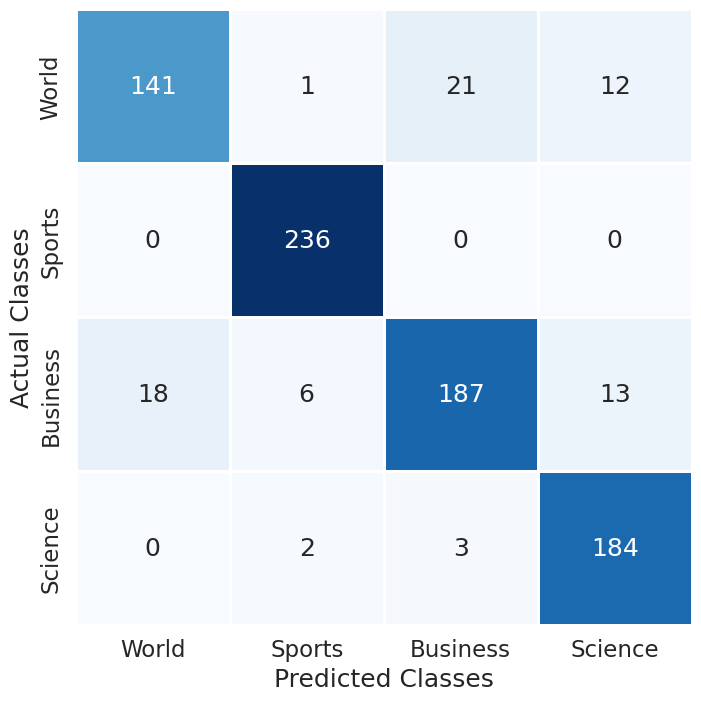

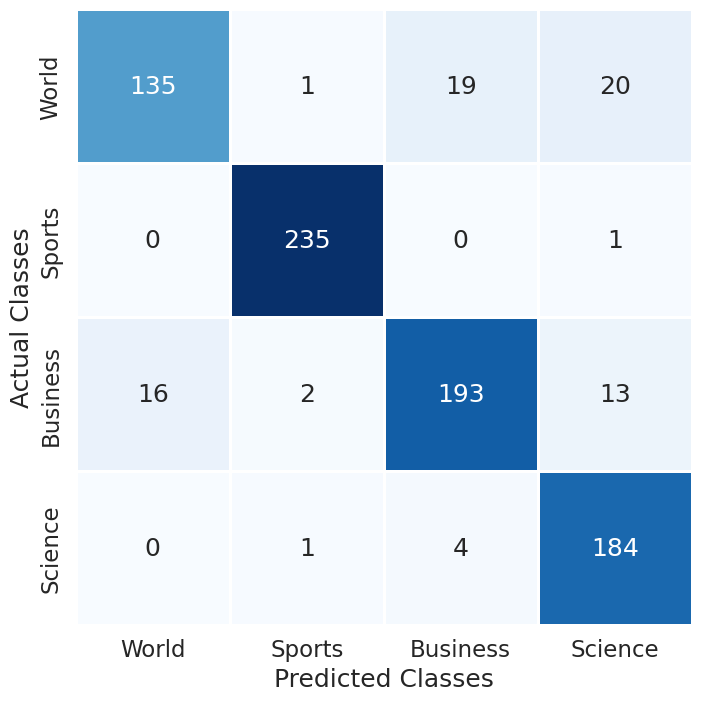

In [51]:
# Lấy nhãn thực tế
y_true = df_new['ID'] 

# ==============================================================================
# 1. ĐÁNH GIÁ TRÊN VĂN BẢN GỐC (FULL TEXT)
# ==============================================================================
print("\n" + "="*40)
print(" KẾT QUẢ ĐÁNH GIÁ TRÊN VĂN BẢN GỐC (FULL TEXT)")
print("="*40)

# In báo cáo chi tiết
eval_model(y_true, pred_full)

# Tính độ chính xác
acc_full = accuracy_score(y_true, pred_full)
print(f">> Accuracy: {acc_full*100:.2f}%")
c = round(acc_full*100, 3) # Biến c này được dùng bên trong hàm eval_model hoặc confusion_mat nếu có

# --- BƯỚC QUAN TRỌNG: CẬP NHẬT BIẾN TOÀN CỤC ---
# Vì hàm confusion_mat() của bạn lấy trực tiếp biến 'test_y' và 'pred' từ bên ngoài
test_y = y_true 
pred = pred_full 

# Giờ mới gọi hàm vẽ
confusion_mat('Blues')


# ==============================================================================
# 2. ĐÁNH GIÁ TRÊN VĂN BẢN TÓM TẮT (SUMMARY)
# ==============================================================================
print("\n" + "="*40)
print(" KẾT QUẢ ĐÁNH GIÁ TRÊN VĂN BẢN TÓM TẮT (SUMMARY)")
print("="*40)

# In báo cáo chi tiết
eval_model(y_true, pred_summary)

# Tính độ chính xác
acc_summary = accuracy_score(y_true, pred_summary)
print(f">> Accuracy: {acc_summary*100:.2f}%")
c = round(acc_summary*100, 3)

# --- BƯỚC QUAN TRỌNG: CẬP NHẬT BIẾN TOÀN CỤC ---
test_y = y_true
pred = pred_summary

# Giờ mới gọi hàm vẽ
confusion_mat('Blues')